In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import glob
import numpy as np

from torch.autograd import Variable
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader



## Load the data

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset

def normalize(data, data_max, data_min):
    return (data - data_min) * 2 / (data_max - data_min) - 1

def unnormalize(data, data_max, data_min):
    return (data + 1) * (data_max - data_min) / 2 + data_min

class PoseDataset(Dataset):
    def __init__(self, name, data_path, mode, data_len=-1, test_full=False):
        self.name = name
        self.data_path = data_path
        self.mode = mode
        self.train_data_len = data_len
        self.test_full = test_full

        # Get normalization stats from training data
        train_loc = np.load(f'{data_path}/loc_train_{name}.npy', allow_pickle=True)
        train_vel = np.load(f'{data_path}/vel_train_{name}.npy', allow_pickle=True)

        # Check if data has dynamic length
        self.dynamic_len = not hasattr(train_loc, 'max')

        # Calculate min/max values
        if self.dynamic_len:
            self.loc_max = max(x.max() for x in train_loc)
            self.loc_min = min(x.min() for x in train_loc)
            self.vel_max = max(x.max() for x in train_vel)
            self.vel_min = min(x.min() for x in train_vel)
        else:
            self.loc_max = train_loc.max()
            self.loc_min = train_loc.min()
            self.vel_max = train_vel.max()
            self.vel_min = train_vel.min()

        # Load and process data
        self._load_data()

    def _load_data(self):
        # Load location and velocity data
        loc_feat = np.load(f'{self.data_path}/loc_{self.mode}_{self.name}.npy')
        vel_feat = np.load(f'{self.data_path}/vel_{self.mode}_{self.name}.npy')

        # Normalize features
        if self.dynamic_len:
            loc_feat = [normalize(f, self.loc_max, self.loc_min) for f in loc_feat]
            vel_feat = [normalize(f, self.vel_max, self.vel_min) for f in vel_feat]
            self.feat = [torch.from_numpy(np.concatenate([l, v], axis=-1).astype(np.float32))
                        for l, v in zip(loc_feat, vel_feat)]
        else:
            loc_feat = normalize(loc_feat, self.loc_max, self.loc_min)
            vel_feat = normalize(vel_feat, self.vel_max, self.vel_min)
            self.feat = torch.from_numpy(np.concatenate([loc_feat, vel_feat], axis=-1).astype(np.float32))

            if self.mode == 'test' and not self.test_full:
                self.feat = self.feat[:, :49]

    def __getitem__(self, index):
        inputs = self.feat[index]

        if self.mode == 'train' and self.train_data_len > 0:
            size = len(inputs)
            if size > self.train_data_len:
                start_ind = np.random.randint(0, size - self.train_data_len)
                inputs = inputs[start_ind:start_ind + self.train_data_len]

        return {'inputs': inputs}

    def __len__(self):
        return len(self.feat)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DATA_PATH='drive/MyDrive/Colab Notebooks/Chapter 7 - Dynamic Graphs/35'


In [5]:

train_data = PoseDataset('cmu', DATA_PATH, 'train', )
val_data = PoseDataset('cmu', DATA_PATH, 'valid', )


In [6]:
import random
def seed(seed_val):
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    random.seed(seed_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_val)



## NRI Model

In [7]:
def encode_onehot(labels):
    """Convert labels to one-hot encoding."""
    unique_labels = sorted(set(labels))
    onehot = np.eye(len(unique_labels))
    return onehot[np.searchsorted(unique_labels, labels)]

class RefNRIMLP(nn.Module):
    """Two-layer fully-connected ELU net with optional batch norm."""

    def __init__(self, n_in, n_hid, n_out, dropout_prob=0., no_bn=False):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_in, n_hid),
            nn.ELU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Linear(n_hid, n_out),
            nn.ELU(inplace=True),
            nn.BatchNorm1d(n_out) if not no_bn else nn.Identity()
        )

        # Initialize weights
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.1)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        # Reshape if needed for BatchNorm
        orig_shape = x.shape
        if len(orig_shape) > 2:
            x = x.view(-1, orig_shape[-1])

        x = self.net(x)

        # Restore original shape if needed
        if len(orig_shape) > 2:
            x = x.view(*orig_shape[:-1], -1)

        return x

In [8]:
class BaseNRI(nn.Module):
    def __init__(self, num_vars, encoder, decoder,
                 num_edge_types=2,
                 gumbel_temp=0.5,
                 prior_variance=5e-5,
                 kl_coef=1.0):
        super().__init__()
        self.num_vars = num_vars
        self.encoder = encoder
        self.decoder = decoder
        self.num_edge_types = num_edge_types
        self.gumbel_temp = gumbel_temp
        self.prior_variance = prior_variance
        self.kl_coef = kl_coef

        # Initialize prior distribution
        prior = torch.zeros(num_edge_types).fill_(1.0 / num_edge_types)
        self.log_prior = torch.log(prior).unsqueeze(0).unsqueeze(0)
        self.log_prior = self.log_prior.cuda(non_blocking=True)

    def _compute_nll(self, preds, target):
        neg_log_p = (preds - target) ** 2 / (2 * self.prior_variance)
        const = 0.5 * np.log(2 * np.pi * self.prior_variance)
        return (neg_log_p.sum(-1) + const).view(preds.size(0), -1).mean(dim=1)

    def _compute_kl(self, probs):
        kl = probs * (torch.log(probs + 1e-16) - self.log_prior)
        return kl.sum(-1).view(probs.size(0), -1).mean(dim=1)

    def calculate_loss(self, inputs, is_train=False, teacher_forcing=True,
                      return_edges=False, return_logits=False):
        # Get encoder outputs and sample edges
        logits = self.encoder(inputs)['logits']
        edges = F.gumbel_softmax(logits.view(-1, self.num_edge_types),
                              tau=self.gumbel_temp,
                              hard=not is_train).view(logits.shape)

        # Get predictions and calculate losses
        output = self.decoder(inputs[:, :-1], edges)
        target = inputs[:, 1:, :, :] if len(inputs.shape) > 3 else inputs[:, 1:]

        loss_nll = self._compute_nll(output, target)
        loss_kl = self._compute_kl(F.softmax(logits, dim=-1))
        loss = (loss_nll + self.kl_coef * loss_kl).mean()

        if return_edges:
            return loss, loss_nll, loss_kl, edges
        elif return_logits:
            return loss, loss_nll, loss_kl, logits, output
        return loss, loss_nll, loss_kl

    def predict_future(self, inputs, prediction_steps,
                      return_edges=False, return_everything=False):
        logits = self.encoder(inputs)['logits']
        edges = F.gumbel_softmax(logits.view(-1, self.num_edge_types),
                               tau=self.gumbel_temp,
                               hard=True).view(logits.shape)

        tmp_predictions, decoder_state = self.decoder(
            inputs[:, :-1], edges, return_state=True)

        predictions = self.decoder(
            inputs[:, -1].unsqueeze(1), edges,
            prediction_steps=prediction_steps,
            teacher_forcing=False,
            state=decoder_state)

        if return_everything:
            predictions = torch.cat([tmp_predictions, predictions], dim=1)

        return (predictions, edges) if return_edges else predictions


## Encoder model


In [9]:

class BaseEncoder(nn.Module):
    def __init__(self, num_vars):
        super(BaseEncoder, self).__init__()
        self.num_vars = num_vars
        edges = torch.ones(num_vars)\
- torch.eye(num_vars)
        self.send_edges, self.\
recv_edges = torch.where(edges)

        one_hot_recv = torch.nn.functional.one_hot(
          self.recv_edges,
          num_classes=num_vars
                                            )
        self.edge2node_mat = \
nn.Parameter(one_hot_recv.\
float().T, requires_grad=False)

    def node2edge(self, node_embeddings):
        send_embed = \
node_embeddings[:, self.send_edges]
        recv_embed = \
node_embeddings[:, self.recv_edges]
        return torch.\
cat([send_embed, recv_embed], dim=2)

    def edge2node(self, edge_embeddings):
        incoming = torch.\
matmul(self.edge2node_mat, edge_embeddings)
        return incoming / (self.num_vars - 1)

    def forward(self, inputs, state=None, return_state=False):
        raise NotImplementedError


In [10]:
class RefMLPEncoder(BaseEncoder):
    def __init__(self,
            num_vars=31,
            input_size=6,
            input_time_steps=50,
            encoder_mlp_hidden=256,
            encoder_hidden=256,
            num_edge_types=2,
            encoder_dropout=0.):
        super(RefMLPEncoder, self).__init__(num_vars)
        inp_size = input_size * input_time_steps
        hidden_size = encoder_hidden
        num_layers = 3
        self.input_time_steps = input_time_steps

        self.mlp1 = RefNRIMLP(inp_size, hidden_size, hidden_size, encoder_dropout)
        self.mlp2 = RefNRIMLP(hidden_size*2, hidden_size,hidden_size, encoder_dropout)
        self.mlp3 = RefNRIMLP(hidden_size, hidden_size,hidden_size, encoder_dropout)
        mlp4_inp_size = hidden_size * 2
        self.mlp4 = RefNRIMLP(mlp4_inp_size, hidden_size,hidden_size, encoder_dropout)

        layers = [nn.Linear(hidden_size, encoder_mlp_hidden), nn.ELU(inplace=True)]
        layers += [nn.Linear(encoder_mlp_hidden, encoder_mlp_hidden),
                  nn.ELU(inplace=True)] * (num_layers - 2)
        layers.append(nn.Linear(encoder_mlp_hidden, num_edge_types))
        self.fc_out = nn.Sequential(*layers)
        self.init_weights()


    def node2edge(self, node_embeddings):
        send_embed = node_embeddings[:, self.send_edges, :]
        recv_embed = node_embeddings[:, self.recv_edges, :]
        return torch.cat([send_embed, recv_embed], dim=2)

    def edge2node(self, edge_embeddings):
        incoming = torch.matmul(self.edge2node_mat, edge_embeddings)
        return incoming/(self.num_vars-1)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.1)

    def merge_states(self, states):
        return torch.cat(states, dim=0)

    def forward(self, inputs, state=None, return_state=False):
          if inputs.size(1) > self.input_time_steps:
              inputs = inputs[:, -self.input_time_steps:]
          elif inputs.size(1) < self.input_time_steps:
              begin_inp = inputs[:, 0:1].expand(
              -1,
              self.input_time_steps-inputs.size(1),
              -1, -1
              )
              inputs = torch.cat([begin_inp, inputs], dim=1)

          x = inputs.transpose(1, 2).contiguous()
          x = x.view(inputs.size(0), inputs.size(2), -1)

          x = self.mlp1(x)
          x = self.node2edge(x)
          x = self.mlp2(x)

          x = self.edge2node(x)
          x = self.mlp3(x)

          x = self.node2edge(x)
          x = self.mlp4(x)

          result =  self.fc_out(x)
          result_dict = {
              'logits': result,
              'state': inputs,
              }
          return result_dict


## Decoder

In [11]:
class CustomGRU(nn.Module):
    def __init__(self, input_size, n_hid, num_vars=31):
        super(CustomGRU, self).__init__()
        self.num_vars = num_vars

        # Hidden state transformations
        self.hidden_r = nn.Linear(n_hid, n_hid, bias=False)
        self.hidden_i = nn.Linear(n_hid, n_hid, bias=False)
        self.hidden_h = nn.Linear(n_hid, n_hid, bias=False)

        # Input transformations
        self.input_r = nn.Linear(input_size, n_hid, bias=True)
        self.input_i = nn.Linear(input_size, n_hid, bias=True)
        self.input_n = nn.Linear(input_size, n_hid, bias=True)

    def forward(self, inputs, agg_msgs, hidden):
        # Reshape inputs
        inp_r = self.input_r(inputs).view(inputs.size(0), self.num_vars, -1)
        inp_i = self.input_i(inputs).view(inputs.size(0), self.num_vars, -1)
        inp_n = self.input_n(inputs).view(inputs.size(0), self.num_vars, -1)

        # GRU operations
        r = torch.sigmoid(inp_r + self.hidden_r(agg_msgs))
        i = torch.sigmoid(inp_i + self.hidden_i(agg_msgs))
        n = torch.tanh(inp_n + r * self.hidden_h(agg_msgs))
        hidden = (1 - i) * n + i * hidden

        return hidden

In [12]:

class GraphRNNDecoder(nn.Module):
    def __init__(self, num_vars=31, input_size=6, decoder_dropout=0.,
                 decoder_hidden=64, num_edge_types=2, skip_first=True):
        super(GraphRNNDecoder, self).__init__()
        self.num_vars = num_vars
        self.msg_out_shape = decoder_hidden
        self.skip_first_edge_type = skip_first
        self.dropout_prob = decoder_dropout
        self.edge_types = num_edge_types

        # Message passing networks
        self.msg_fc1 = nn.ModuleList([
            nn.Linear(2 * decoder_hidden, decoder_hidden)
            for _ in range(self.edge_types)
        ])
        self.msg_fc2 = nn.ModuleList([
            nn.Linear(decoder_hidden, decoder_hidden)
            for _ in range(self.edge_types)
        ])

        # Custom GRU cell
        self.custom_gru = CustomGRU(input_size, decoder_hidden)

        # Output networks
        self.out_fc1 = nn.Linear(decoder_hidden, decoder_hidden)
        self.out_fc2 = nn.Linear(decoder_hidden, decoder_hidden)
        self.out_fc3 = nn.Linear(decoder_hidden, input_size)

        # Edge connectivity setup
        edges = np.ones(num_vars) - np.eye(num_vars)
        self.send_edges = np.where(edges)[0]
        self.recv_edges = np.where(edges)[1]
        self.edge2node_mat = torch.FloatTensor(encode_onehot(self.recv_edges))
        self.edge2node_mat = self.edge2node_mat.cuda(non_blocking=True)

    def single_step_forward(self, inputs, rel_type, hidden):
        # Get receivers and senders
        receivers = hidden[:, self.recv_edges, :]
        senders = hidden[:, self.send_edges, :]
        pre_msg = torch.cat([receivers, senders], dim=-1)

        # Initialize message tensor
        all_msgs = torch.zeros(
            pre_msg.size(0), pre_msg.size(1),
            self.msg_out_shape, device=inputs.device
        )

        # Message passing
        start_idx = 1 if self.skip_first_edge_type else 0
        norm = float(len(self.msg_fc2) - start_idx)

        for i in range(start_idx, len(self.msg_fc2)):
            msg = torch.tanh(self.msg_fc1[i](pre_msg))
            msg = F.dropout(msg, p=self.dropout_prob)
            msg = torch.tanh(self.msg_fc2[i](msg))
            msg = msg * rel_type[:, :, i:i+1]
            all_msgs += msg / norm

        # Aggregate messages
        agg_msgs = all_msgs.transpose(-2, -1)
        agg_msgs = agg_msgs.matmul(self.edge2node_mat)
        agg_msgs = agg_msgs.transpose(-2, -1) / (self.num_vars - 1)

        # Update hidden state
        hidden = self.custom_gru(inputs, agg_msgs, hidden)

        # Generate prediction
        pred = F.dropout(F.relu(self.out_fc1(hidden)), p=self.dropout_prob)
        pred = F.dropout(F.relu(self.out_fc2(pred)), p=self.dropout_prob)
        pred = self.out_fc3(pred)

        pred = inputs + pred
        return pred, hidden

    def forward(self, inputs, sampled_edges,
                teacher_forcing=False,
                teacher_forcing_steps=-1,
                return_state=False,
                prediction_steps=-1,
                state=None):
        batch_size, time_steps, num_vars, num_feats = inputs.size()
        pred_steps = prediction_steps if prediction_steps > 0 else time_steps

        # Expand sampled edges if needed
        if len(sampled_edges.shape) == 3:
            sampled_edges = sampled_edges.unsqueeze(1)
            sampled_edges = sampled_edges.expand(batch_size, pred_steps, -1, -1)

        # Initialize hidden state
        if state is None:
            hidden = torch.zeros(
                batch_size, num_vars,
                self.msg_out_shape, device=inputs.device
            )
        else:
            hidden = state
        teacher_forcing_steps = time_steps

        # Generate predictions
        pred_all = []
        for step in range(pred_steps):
            if step == 0 or (teacher_forcing and step < teacher_forcing_steps):
                ins = inputs[:, step, :]
            else:
                ins = pred_all[-1]

            pred, hidden = self.single_step_forward(
                ins, sampled_edges[:, step, :], hidden
            )
            pred_all.append(pred)

        preds = torch.stack(pred_all, dim=1)
        return (preds, hidden) if return_state else preds

## Define model and training hyper-params

In [13]:

num_vars = 31

# Build Encoder
encoder = RefMLPEncoder()
print("ENCODER: ",encoder)

# # Build Decoder
decoder = GraphRNNDecoder()
print("DECODER: ",decoder)

model = BaseNRI(num_vars, encoder, decoder)
model = model.cuda()


ENCODER:  RefMLPEncoder(
  (mlp1): RefNRIMLP(
    (net): Sequential(
      (0): Linear(in_features=300, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mlp2): RefNRIMLP(
    (net): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mlp3): RefNRIMLP(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=Fal

In [14]:
gpu = True
batch_size = 8
val_batch_size = batch_size

num_epochs = 100

clip_grad = None
clip_grad_norm = None
val_teacher_forcing = True
tune_on_nll = True

train_data_loader = DataLoader(train_data,
                               batch_size=batch_size,
                               shuffle=True,
                               drop_last=True)

val_data_loader = DataLoader(val_data, batch_size=val_batch_size)
lr = 5e-4
decay_factor = 0.5
decay_steps = 300
wd = 0.


In [15]:

def build_scheduler(opt, lr_decay_factor=0.5, lr_decay_steps=300):
    if lr_decay_factor:
        return torch.optim.lr_scheduler.StepLR(opt, lr_decay_steps, lr_decay_factor)
    else:
        return None


## Train the Model


In [16]:
model_params = [param for param in model.parameters() if param.requires_grad]
opt = torch.optim.Adam(model_params, lr=lr, weight_decay=wd)


In [17]:
start_epoch = 1
best_val_epoch = -1
best_val_result = 10000000


In [18]:
# training_scheduler = torch.optim.lr_scheduler.StepLR(opt, 0.5, 300)
training_scheduler = build_scheduler(opt)

end = start = 0
seed(1)


In [19]:
from tqdm import tqdm

pbar = tqdm(range(start_epoch, num_epochs + 1), desc='Epochs')
for epoch in pbar:
    model.train()
    model.train_percent = epoch / num_epochs
    total_training_loss = 0

    for batch in train_data_loader:
        inputs = batch['inputs']
        if gpu:
            inputs = inputs.cuda(non_blocking=True)

        loss, loss_nll, loss_kl, logits, _ = model.calculate_loss(
            inputs,
            is_train=True,
            return_logits=True
        )
        loss.backward()

        # Handling gradient clipping
        if clip_grad is not None:
            nn.utils.clip_grad_value_(model.parameters(), clip_grad)
        elif clip_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        opt.step()
        opt.zero_grad()
        total_training_loss += loss.item()

    if training_scheduler is not None:
        training_scheduler.step()

    # Validation phase
    model.eval()
    total_nll, total_kl = 0, 0

    with torch.no_grad():
        for batch in val_data_loader:
            inputs = batch['inputs']
            if gpu:
                inputs = inputs.cuda(non_blocking=True)

            _, loss_nll, loss_kl, _, _ = model.calculate_loss(
                inputs,
                is_train=False,
                teacher_forcing=val_teacher_forcing,
                return_logits=True
            )
            total_kl += loss_kl.sum().item()
            total_nll += loss_nll.sum().item()

    total_kl /= len(val_data)
    total_nll /= len(val_data)
    total_loss = model.kl_coef * total_kl + total_nll

    tuning_loss = total_nll if tune_on_nll else total_loss

    if tuning_loss < best_val_result:
        best_val_epoch, best_val_result = epoch, tuning_loss

    # Update progress bar with metrics
    pbar.set_postfix({
        'train_loss': f'{total_training_loss:.4f}',
        'val_loss': f'{tuning_loss:.4f}',
        'best_val': f'{best_val_result:.4f}'
    })

Epochs: 100%|██████████| 100/100 [04:04<00:00,  2.45s/it, train_loss=520.5753, val_loss=50.5166, best_val=45.2615]


## Test the model

In [20]:


def eval_forward_prediction(model, dataset, burn_in_steps, forward_pred_steps, gpu=True, batch_size=8, return_total_errors=False):
    dataset.return_edges = False

    data_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=gpu)
    model.eval()
    total_se = 0
    batch_count = 0
    all_errors = []
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        with torch.no_grad():
            model_inputs = inputs[:, :burn_in_steps]
            gt_predictions = inputs[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            if gpu:
                model_inputs = model_inputs.cuda(non_blocking=True)
            model_preds = model.predict_future(model_inputs, forward_pred_steps).cpu()
            batch_count += 1
            if return_total_errors:
                all_errors.append(F.mse_loss(model_preds, gt_predictions, reduction='none').view(model_preds.size(0), model_preds.size(1), -1).mean(dim=-1))
            else:
                total_se += F.mse_loss(model_preds, gt_predictions, reduction='none').view(model_preds.size(0), model_preds.size(1), -1).mean(dim=-1).sum(dim=0)
    if return_total_errors:
        return torch.cat(all_errors, dim=0)
    else:
        return total_se / len(dataset)

In [21]:
test_data = PoseDataset('cmu', DATA_PATH, 'test', test_full=True)
mode='eval'
if mode == 'eval':
    test_cumulative_mse = eval_forward_prediction(model, test_data, 50, 48)

    test_mse_1 = test_cumulative_mse[0].item()
    test_mse_20 = test_cumulative_mse[19].item()
    test_mse_40 = test_cumulative_mse[39].item()
    print("FORWARD PRED RESULTS:")
    print("\t1 STEP:  ",test_mse_1)
    print("\t20 STEP: ", test_mse_20)
    print("\t40 STEP: ",test_mse_40)


FORWARD PRED RESULTS:
	1 STEP:   8.735097071621567e-05
	20 STEP:  0.001387310680001974
	40 STEP:  0.0033900137059390545


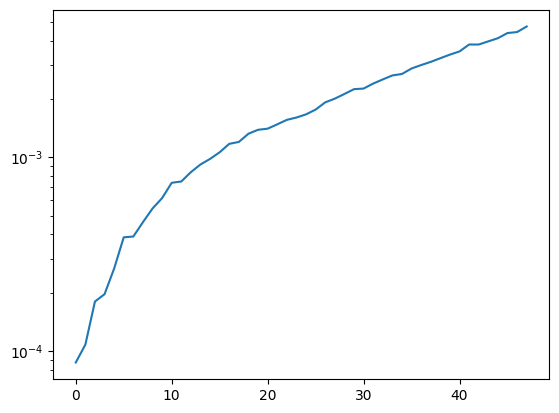

In [22]:
import matplotlib.pyplot as plt
plt.semilogy(test_cumulative_mse)

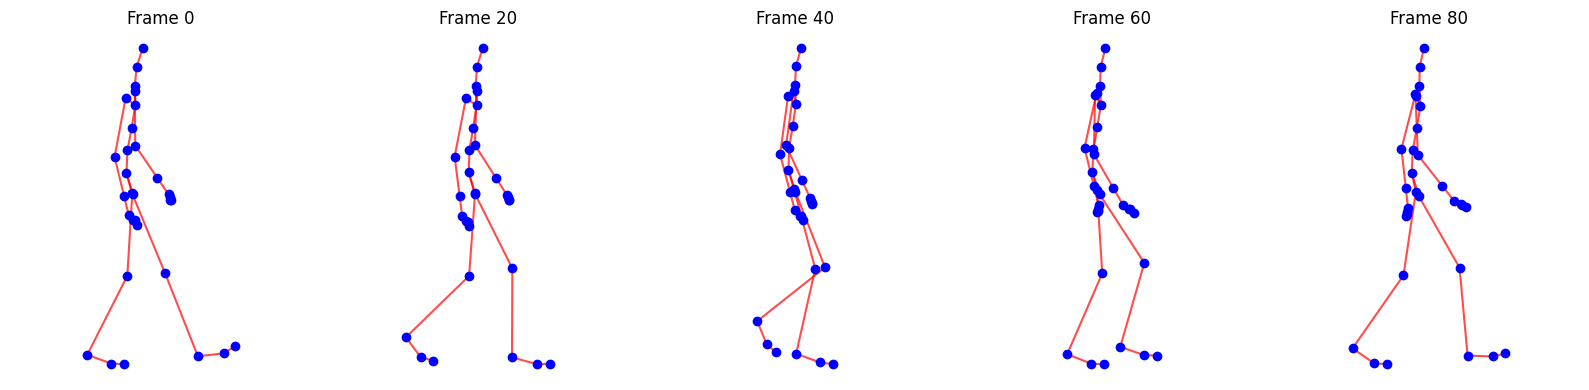

In [23]:
def plot_frame(positions, edges, title="Motion Frame"):
    plt.figure(figsize=(8, 8))

    for i, j in edges:
        plt.plot([positions[i, 2], positions[j, 2]],
                [-positions[i, 1], -positions[j, 1]], 'r-', alpha=0.7)

    plt.scatter(positions[:, 2], -positions[:, 1], c='blue', zorder=2)

    plt.title(title)
    plt.axis('equal')
    plt.grid(True)

edges = np.load(f'{DATA_PATH}/edges.npy')

# Get entire test sequence
sample = test_data[0]['inputs']  # Shape: [100, 31, 6]

# Plot every 20th frame
frames_to_plot = range(0, len(sample), 20)
num_frames = len(frames_to_plot)

plt.figure(figsize=(16, 4))
for idx, frame_num in enumerate(range(0, 100, 20), 1):
    ax = plt.subplot(1, 5, idx)

    positions = sample[frame_num, :, :3]
    if isinstance(positions, torch.Tensor):
        positions = positions.numpy()

    for i, j in edges:
        plt.plot([positions[i, 2], positions[j, 2]],
                [positions[i, 1], positions[j, 1]], 'r-', alpha=0.7)

    plt.scatter(positions[:, 2], positions[:, 1], c='blue', zorder=2)

    plt.title(f'Frame {frame_num}')
    plt.axis('equal')
    # Remove ticks and boxes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()